<a href="https://colab.research.google.com/github/tommycwong/ML-ElectronMicroscopy-2023/blob/main/Lecture%2013/ML4EM_Summer2023_Data_Augmentation_supp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML for Electron Microscopy Summer 2023: Data Augmentation Supplement
Prepared by Tommy Wong, with sections adopted from Maxim Ziatdinov enabled by [AtomAI](https://github.com/pycroscopy/atomai). Data made available by Shradha Agarwal.

This notebook provides supplementary examples for data augmentation techniques: sliding widow cropping and adding transformations and noises to images.

**To run this notebook, click Runtime -> Run all. Make sure to specify filenames and uncomment cells according to instructions.**

---

Download AtomAI for image augmentation:

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-q3m45fym
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-q3m45fym
  Resolved https://github.com/pycroscopy/atomai to commit 6d187296074143d017ca8fc60302364cd946b180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 45.1 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8-py3-none-any.whl size=162558 sha256=5ac41a37ef376a81a9568f0a4fedd528d2b77f0d23df3be247830d3a0815a300
  Stored in directory: /tmp/pip-ephem-wheel-cache-3emxg0xo/wheels/ca/13/12/fc0f90d0fce48063154d2a5f9fc755aee641d61d21f58f1800
  Created wheel for 

Import modules:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import atomai as aoi

It is important to normalize pixels to between 0 and 1 for training with a neural network. Here is a simple function for normalization of a single image:

In [ ]:
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

Download training image and label from GitHub. Mount Google Drive or use `!gdown` instead to access images on Google Drive. Augmentation has to be performed on both images and labels to ensure correspondance. This notebook assumes the data has already been preprocessed into numpy/pickle formats (refer to Data Labeling notebook).

In [ ]:
#Training images 1 2
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_12.npy'
#Training images 1 2 U-Net masks
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_12_unet_mask.npy'
#Training images 1 2 Mask R-CNN masks
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_12_maskRcnn_mask.pickle'

--2023-07-17 23:46:47--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_12.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2097280 (2.0M) [application/octet-stream]
Saving to: ‘DL_for_Microscopy_Train_Img_12.npy’

DL_for_Microscopy_T 100%[===================>]   2.00M  --.-KB/s    in 0.04s   

2023-07-17 23:46:47 (46.5 MB/s) - ‘DL_for_Microscopy_Train_Img_12.npy’ saved [2097280/2097280]

--2023-07-17 23:46:47--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_12_unet_mask.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.gi

Load and show the training images with size 512 by 512. **Specify your numpy image filename here.**

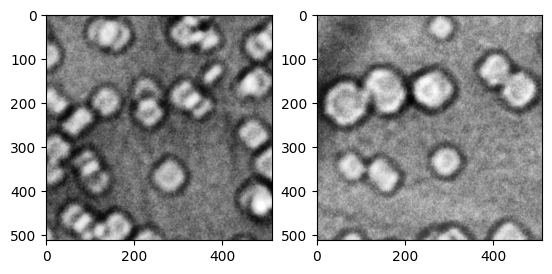

In [ ]:
# Specify your filename here:
train_imgs_filename = 'DL_for_Microscopy_Train_Img_12.npy'
train_imgs = np.load(train_imgs_filename)

# Show the training imgs:
fig, ax = plt.subplots(1, len(train_imgs))
for i in range(len(train_imgs)):
    ax[i].imshow(train_imgs[i], cmap='gist_gray')

## Sliding window cropping

Define functions for cropping. Cropping using a sliding window allows small amount of microscopy data to be diversified into more data for training. Convolutional neural networks (CNNs) also do not perform well with extremely large images common in microscopy. Two slightly different cropping functions are provided for U-Net and Mask R-CNN: `unet_cropper` and `maskRcnn_cropper`.

In [ ]:
#@title Cropping functions:
import numpy as np

class cropper:
    """
    Augments an input image-mask pair by performing image cropping procedure
    """
    def __init__(self, image, mask, window_size, step_size):
        """
        Args:
            image (2d ndarray): image to be cropped (height x width),
            mask (3d ndarray): mask/ground truth (height x width x channels),
            window_size (tuple): width and height of sliding window,
            step_size (float): step size of sliding window,
            batch_size (int): number of images to return.
        """
        if np.ndim(image) == 2:
            image = np.expand_dims(image, axis=2)
        self.image = image
        if np.ndim(mask) == 2:
            mask = np.expand_dims(mask, axis=2)
        self.mask = mask
        self.window_size = window_size
        self.step_size = step_size

    def sliding_window(self):
        """
        Returns the portion of the input image lying within sliding window
        """
        for y in range(0, self.image.shape[0], self.step_size):
            for x in range(0, self.image.shape[1], self.step_size):
                yield (self.image[y:y + self.window_size[1], x:x + self.window_size[0], :],
                       self.mask[y:y + self.window_size[1], x:x + self.window_size[0], :])

    def imgen(self):
        """
        Returns a batch of cropped images and
        a batch of corresponding labels (ground truth)
        """
        X_batch = np.empty((0, self.window_size[0], self.window_size[1]))
        y_batch = []
        for window in self.sliding_window():
            if window[0].shape[: -1] != self.window_size:
                continue
            window_i = np.transpose(window[0], [2, 0, 1])   # img
            window_i = (window_i - np.amin(window_i))/np.ptp(window_i) # normalize img
            window_l = np.transpose(window[1], [2, 0, 1])   # lab
            # remove masks w/o bubbles
            window_l = window_l[np.any(window_l != 0, axis=(1, 2))]
            X_batch = np.append(X_batch, window_i, axis=0)
            y_batch.append(window_l)
        if len(X_batch) != len(y_batch):
            return 'no. of image patches does not match no. of label patches'
        return X_batch, y_batch

    def norm2D(img):
        return (img - np.amin(img))/np.ptp(img)

def unet_cropper(img, mask, window_size, step_size):
    """
    input:
    img, mask in np.array([N, H, W]) where N is no. of imgs/masks
    window_size, step_size: int, square windows with stride of step_size
    return:
    img_patches and lab_patches in np.array([N, H, W]) where N is no. of patches
    """
    img_patches = []; lab_patches = []
    for i in range(len(img)):
        imcrop = cropper(img[i], mask[i], (window_size, window_size), step_size)
        img_patch, lab_patch = imcrop.imgen()
        lab_patch = np.stack(lab_patch, axis=0)[:, 0, ...]
        img_patches.append(img_patch)
        lab_patches.append(lab_patch)
    return np.vstack(img_patches), np.vstack(lab_patches)

def maskRcnn_cropper(img, mask, window_size, step_size):
    """
    input:
    img, mask in np.array([N, H, W]) where N is no. of imgs/masks
    window_size, step_size: int, square windows with stride of step_size
    return:
    img_patches in np.array([N, H, W]) where N is no. of patches
    lab_patches as list with N np.array([H, W, C]) where C is no. of features/img
    """
    img_patches = []; lab_patches = []
    for i in range(len(img)):
        imcrop = cropper(img[i], mask[i], (window_size, window_size), step_size)
        img_patch, lab_patch = imcrop.imgen()
        img_patches.append(img_patch)
        lab_patches.append(lab_patch)
    img_patches = np.vstack(img_patches)
    lab_patches = [item for sublist in lab_patches for item in sublist]
    lab_patches_ = []
    for l in lab_patches:
        lab_patches_.append(np.moveaxis(l, 0, -1))
    return img_patches, lab_patches_

### U-Net cropping:

**Specify filename** and load the U-Net masks:

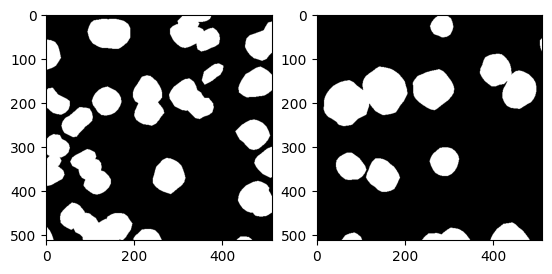

In [ ]:
unet_mask = np.load('DL_for_Microscopy_Train_Img_12_unet_mask.npy')

# Show the masks:
fig, ax = plt.subplots(1, len(unet_mask))
for i in range(len(unet_mask)):
    ax[i].imshow(unet_mask[i], cmap='gist_gray')

Crop the U-Net images/masks into patches of 256 by 256 with step size/stride of 128 (half of window size):

In [ ]:
unet_img_patches, unet_mask_patches = unet_cropper(train_imgs, unet_mask, window_size=256, step_size=128)

Display a few cropped patches:

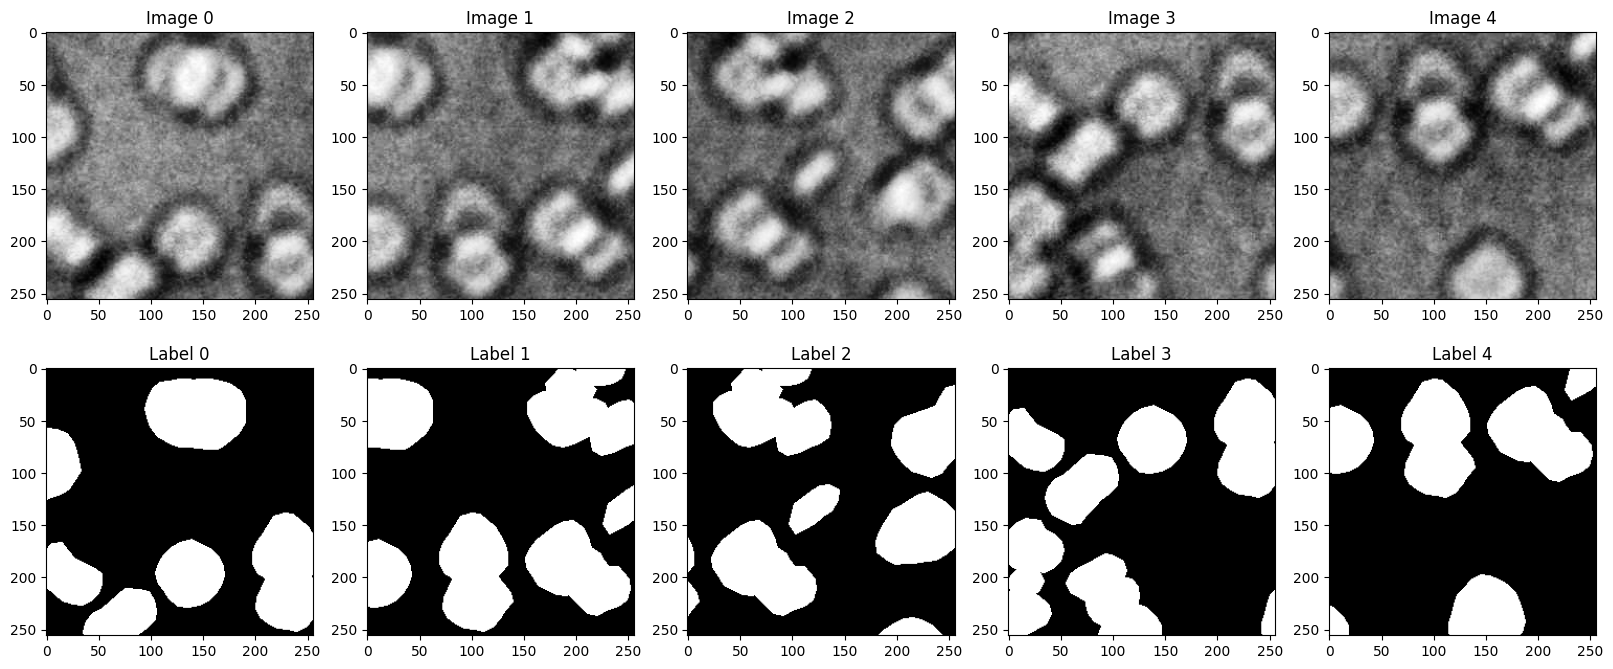

In [ ]:
#@title Show patches:
fig = plt.figure(figsize=(20, 8))
for i in range(1, 6):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(unet_img_patches[i-1, ...], cmap='gist_gray')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(unet_mask_patches[i-1, ...], cmap='gist_gray')
    ax.set_title('Label ' + str(i-1))

### Mask R_CNN cropping:

Define functions that generate Mask R-CNN dataset (same as in Data Labeling notebook):

In [ ]:
#@title Mask R-CNN dataset functions:
import cv2
import torch

# Creates bounding boxes
# masks shape = [N, H, W]
def boundbox(masks, maxDim):    # bounding boxes [x1 y1 x2 y2]
    num_objs = len(masks)
    boxes = np.zeros((num_objs, 4))
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes[i, ...] = np.array([xmin, ymin, xmax, ymax])

    boxes[boxes < 0] = 0 # set negative values to 0
    boxes[boxes > maxDim-1] = maxDim-1 # set values larger than image size to max
    # check for bounding boxes with area != 0:
    boolMask = (boxes[:, 0] != boxes[:, 2]) & (boxes[:, 1] != boxes[:, 3])
    # select masks and boxes with area != 0:
    return torch.as_tensor(boxes[boolMask], dtype=torch.float32), masks[boolMask]

# Create the dataset in the format [target{boxes, labels, masks}...] and
# valid images in the format [N, H, W]. [target...] has N entries, each target
# has C entries for C features in a single image. labels are int tensor with C entries
# for C features. masks have shape [C, H, W]. boxes have shape [C, 4], each row
# is [x1 y1 x2 y2].
# inputs: images are in np.array([N, H, W]) where N is the no. of images
# labels are list with N elements of [H, W, C] with C for the number of features (masks) in each image
# maskdim (int) is the size of the square masks == size of images
def get_maskrcnn_dataset(images, labels):
    train_Y = []
    invalid_imgs = []
    maskdim = images.shape[1]
    for i in range(images.shape[0]):
        box_labs = np.moveaxis(labels[i], -1, 0)
        boundboxes, updatedMasks = boundbox(box_labs, maskdim)
        # check for imgs w/o bounding boxes, skip processing and get idx
        if np.any(boundboxes.cpu().detach().numpy()) == False:
            print(f'invalid image: {i}')
            invalid_imgs.append(i)
            continue
        target = {}
        target["boxes"] = boundboxes
        target["labels"] = torch.as_tensor(np.ones(len(boundboxes)), dtype=torch.int64)
        target["masks"] = torch.as_tensor(updatedMasks, dtype=torch.uint8)
        if len(target["boxes"]) == len(target["labels"]) == len(target["masks"]):
            train_Y.append(target)
            print(f'image {i} has {len(boundboxes)} boxes')
        else:
            print('dictionary entries lengths do not match')
            break
    # select only images with labels
    valid_images = np.delete(images, invalid_imgs, axis=0)
    return valid_images, train_Y

**Specify filename** and load the Mask R-CNN masks:

In [ ]:
import pickle
maskRcnn_mask_file = open('DL_for_Microscopy_Train_Img_12_maskRcnn_mask.pickle', 'rb')
maskRcnn_mask = pickle.load(maskRcnn_mask_file)
maskRcnn_mask_file.close()

Crop the Mask R-CNN images/masks into patches of 256 by 256 with step size/stride of 128 (half of window size):

In [ ]:
maskRcnn_img_patches, maskRcnn_mask_patches = maskRcnn_cropper(train_imgs, maskRcnn_mask, window_size=256, step_size=128)

Display a few cropped patches. Note the labels displayed are overlays of individual feature labels.

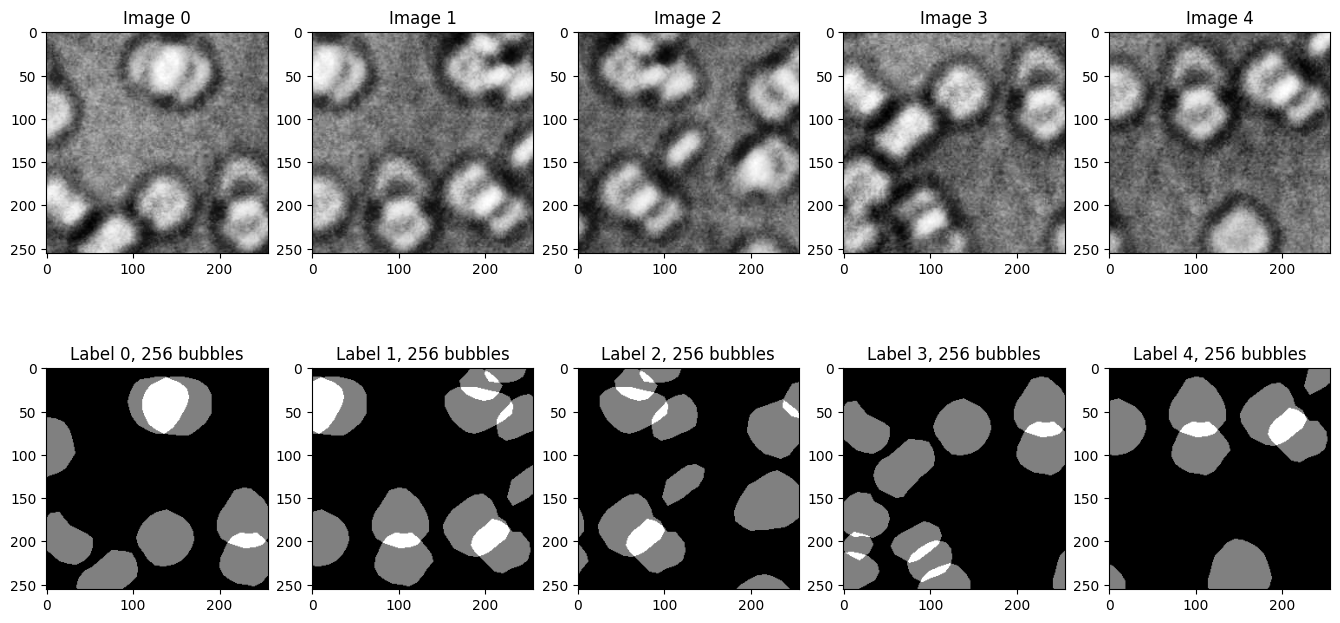

In [ ]:
#@title Show cropped Mask R-CNN patches:
# No of image-label pairs to be displayed
n = 5
n = n + 1

fig = plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(maskRcnn_img_patches[i-1,...], cmap = 'gist_gray')
    ax.set_title(f'Image {str(i-1)}')
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(np.sum(maskRcnn_mask_patches[i-1], axis=-1), cmap = 'gist_gray')
    ax.set_title(f'Label {str(i-1)}, {len(maskRcnn_mask_patches[i-1])} bubbles')

Generate Mask R-CNN dataset:

In [ ]:
maskRcnn_train_imgs, maskRcnn_train_labels = get_maskrcnn_dataset(images=maskRcnn_img_patches, labels=maskRcnn_mask_patches)

image 0 has 8 boxes
image 1 has 12 boxes
image 2 has 13 boxes
image 3 has 12 boxes
image 4 has 8 boxes
image 5 has 10 boxes
image 6 has 15 boxes
image 7 has 6 boxes
image 8 has 7 boxes
image 9 has 3 boxes
image 10 has 4 boxes
image 11 has 5 boxes
image 12 has 5 boxes
image 13 has 5 boxes
image 14 has 4 boxes
image 15 has 4 boxes
image 16 has 4 boxes
image 17 has 4 boxes


Mount Google Drive to save files:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#directory = 'your path here'
#os.chdir(directory)

Save the numpy and pickle files:

In [ ]:
# Save processed images
#np.save('DL_for_Microscopy_mrcnn_train_imgs', maskRcnn_train_imgs)
# Save Mask R-CNN dataset
#import pickle
#with open('DL_for_Microscopy_mrcnn_train_labs.pickle', 'wb') as f:
#    pickle.dump(maskRcnn_train_labels, f)
#f.close()

## Image Augmentation

Define functions for image augmentation:

In [ ]:
#@title Augmentation functions:
import atomai as aoi
import torch
import random

def img_augmentor(images=None, labels=None, nb_classes=1, seed=0, **kwargs):
    '''
    return: augmented images, labels in np.array([N, H, W])
    input:
    images, labels in np.array([N, H, W])
    labels can be replaced with images to only augment images
    nb_classes = no. of classes in labels (default=1)
    kwargs:
    zoom = 1.3 # zoom factor
    poisson_noise = [30, 40] # P noise range (scaled units)
    gauss_noise = [0, 200] # G noise range (scaled units)
    blur = [1, 50] # Blurring range (scaled units)
    contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
    jitter = [0, 50]
    rotation=True
    background=True
    '''
    imaug = aoi.transforms.seg_augmentor(nb_classes=nb_classes, seed=seed, **kwargs)
    images_aug, labels_aug = imaug(torch.from_numpy(images[:, np.newaxis, ...]),
                                   torch.from_numpy(labels[:, np.newaxis, ...]), seed=seed)
    return images_aug.numpy()[:, 0, ...], labels_aug.numpy()[:, 0, ...]

def unet_augmentor(images=None, labels=None, batch_size=32, nb_classes=1, seed=0, **kwargs):
    '''
    return: augmented images, labels in np.array([N, H, W])
    input:
    images, labels in np.array([N, H, W])
    labels can be replaced with images to only augment images
    batch_size = no. of augmented images/labels generated (default=32)
    nb_classes = no. of classes in labels (default=1)
    kwargs:
    zoom = 1.3 # zoom factor
    poisson_noise = [30, 40] # P noise range (scaled units)
    gauss_noise = [0, 200] # G noise range (scaled units)
    blur = [1, 50] # Blurring range (scaled units)
    contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
    jitter = [0, 50]
    rotation=True
    background=True
    '''
    random.seed(seed)
    randidx = random.choices([*range(len(images))], k=batch_size)
    batch_shape = (batch_size, images.shape[1], images.shape[2])
    img_batch = np.zeros(batch_shape); lab_batch = np.zeros(batch_shape)
    for i in range(batch_size):
        img_batch[i] = images[randidx[i]]; lab_batch[i] = labels[randidx[i]]
    imaug = aoi.transforms.seg_augmentor(nb_classes=nb_classes, seed=seed, **kwargs)
    images_aug, labels_aug = imaug(torch.from_numpy(img_batch[:, np.newaxis, ...]),
                                   torch.from_numpy(lab_batch[:, np.newaxis, ...]), seed=seed)
    return images_aug.numpy()[:, 0, ...], labels_aug.numpy()[:, 0, ...]

### Examples of augmented images:

First, define a collection of augmentation values:

In [ ]:
zoom = 1.3 # zoom factor
poisson_noise = [30, 40] # P noise range (scaled units) !Do not change values!
gauss_noise = [0, 200] # G noise range (scaled units)
blur = [1, 50] # Blurring range (scaled units)
contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
jitter = [0, 50]
rotation = True
background = True

rotation:

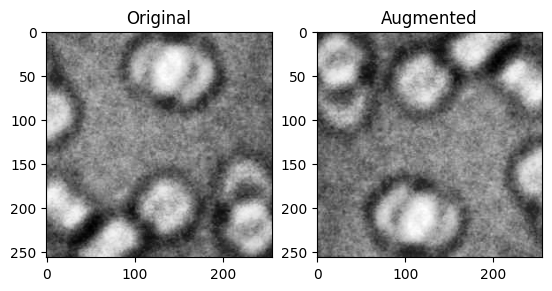

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               rotation=rotation)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

zoom:

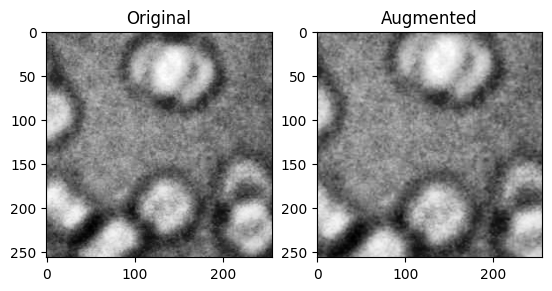

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               zoom=zoom)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

Gaussian noise:

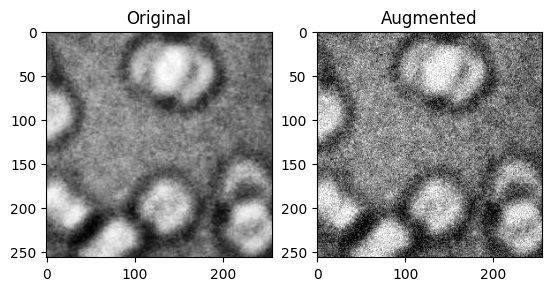

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               gauss_noise=gauss_noise)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

Poisson noise:

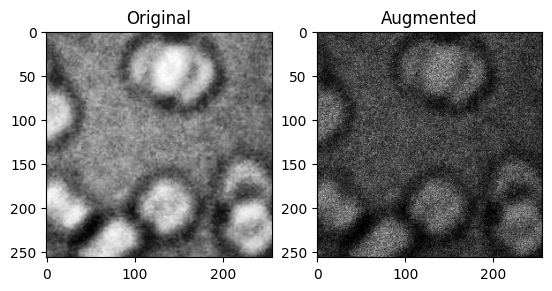

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               poisson_noise=poisson_noise)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

salt and pepper:

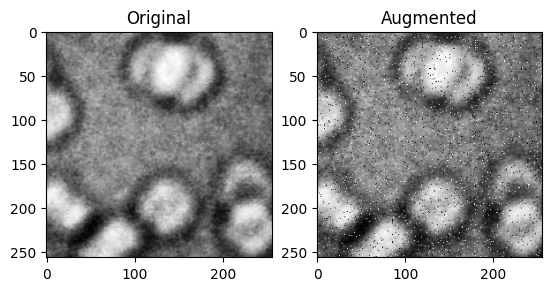

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               salt_and_pepper=salt_and_pepper)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

jitter (more common in scanning probe microscopy):

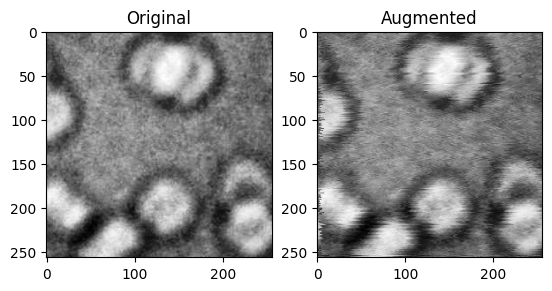

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               jitter=jitter)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

background noise:

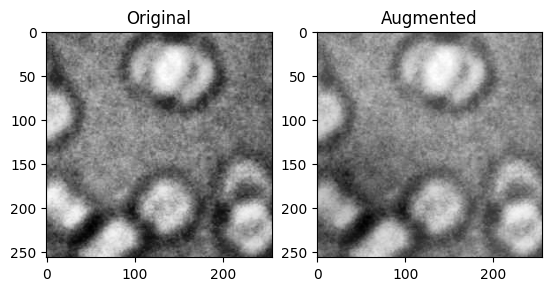

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               background=background)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

blur:

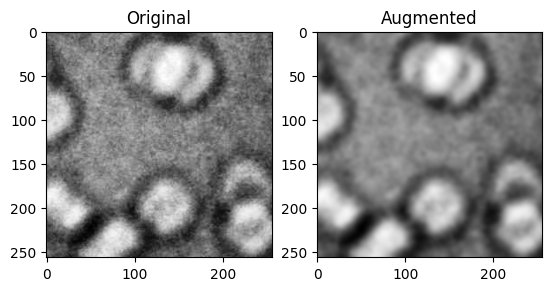

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               blur=blur)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

contrast:

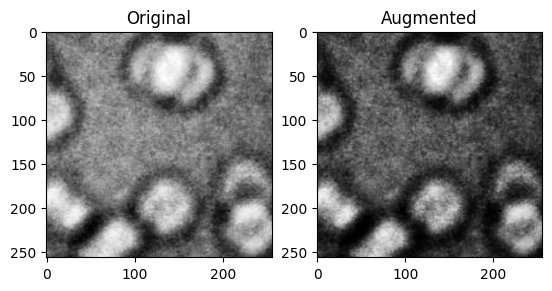

In [ ]:
aug_imgs, aug_labs = img_augmentor(images=unet_img_patches, labels=unet_mask_patches, nb_classes=1, seed=0,
                               contrast=contrast)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Original')
ax[0].imshow(unet_img_patches[0], cmap='gist_gray')
ax[1].set_title('Augmented')
ax[1].imshow(aug_imgs[0], cmap='gist_gray')

### Augmenting U-Net images:

Augment U-Net images. Since the datset isn't that noisy only a low level of noise is added.

In [ ]:
rotation = True
gauss_noise = [0, 50] # G noise range (scaled units)
blur = [1, 20] # Blurring range (scaled units)

unet_img_aug, unet_mask_aug = unet_augmentor(images=unet_img_patches,
                                             labels=unet_mask_patches, nb_classes=1,
                                             seed=0, blur=blur, gauss_noise=gauss_noise,
                                             rotation=rotation)

Show examples of augmented images:

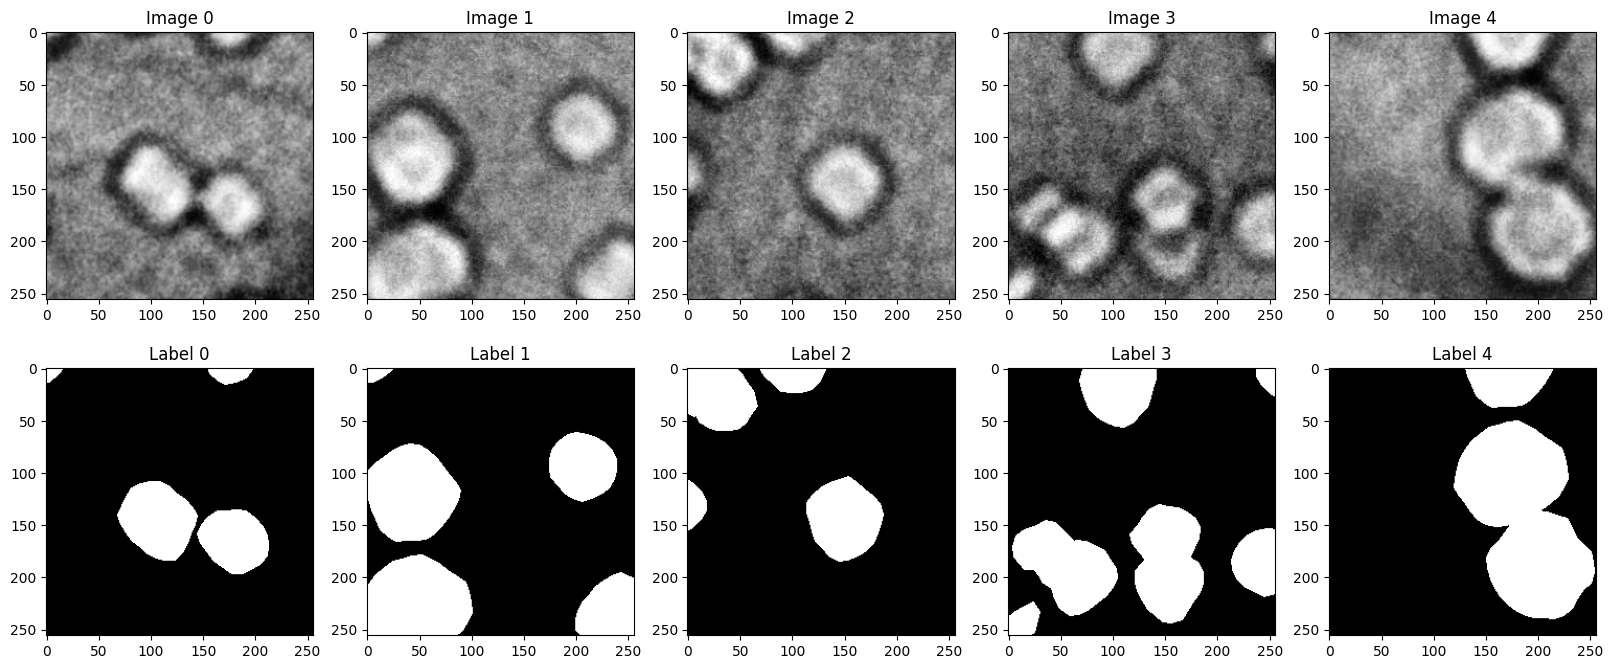

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i in range(1, 6):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(unet_img_aug[i-1, ...], cmap='gist_gray')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(unet_mask_aug[i-1, ...], cmap='gist_gray')
    ax.set_title('Label ' + str(i-1))

Mount Google drive to save the augmented data:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#directory = 'your path here'
#os.chdir(directory)

Save the data as numpy files:

In [ ]:
#np.save('DL_for_Microscopy_unet_train_imgs', unet_img_aug)
#np.save('DL_for_Microscopy_unet_train_labs', unet_mask_aug)